<a href="https://colab.research.google.com/github/son-of-AI/100_day_of_ML/blob/master/LeNET_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision 
import torchvision.transforms as transforms


#initializing general terms

In [24]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

#loading training and test data

In [0]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

In [0]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

#visualising data

In [27]:
examples = iter(train_loader)
images, labels = examples.next()
print(images.shape)

print(images[1].shape)
print(labels[1].item())


torch.Size([64, 1, 28, 28])
torch.Size([1, 28, 28])
3


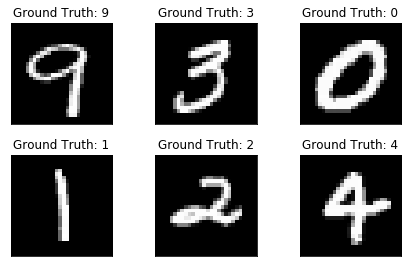

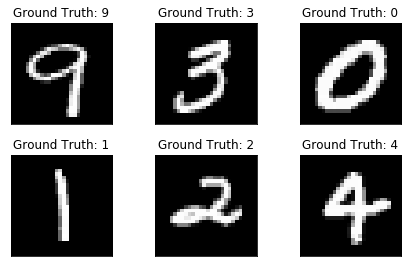

In [28]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])
fig

#creating our LeNet model

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 6, 5),         # (N, 1, 28, 28) -> (N,  6, 24, 24)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 24, 24) -> (N,  6, 12, 12)
            nn.Conv2d(6, 16, 5),        # (N, 6, 12, 12) -> (N, 16, 8, 8)  
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 8, 8) -> (N, 16, 4, 4)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(256,120),         # (N, 256) -> (N, 120)
            nn.ReLU(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.ReLU(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        #print(x.shape)
        x = self.cnn_model(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_model(x)
        #print(x.shape)
        return x

#training LeNet model


In [0]:
Net = LeNet()

loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(Net.parameters())

In [0]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        outputs = Net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Epoch: 0/16, Test acc: 97.66, Train acc: 97.66
Epoch: 1/16, Test acc: 98.32, Train acc: 98.25
Epoch: 2/16, Test acc: 98.80, Train acc: 98.73
Epoch: 3/16, Test acc: 98.32, Train acc: 98.62
Epoch: 4/16, Test acc: 98.95, Train acc: 99.22
Epoch: 5/16, Test acc: 98.66, Train acc: 98.94
Epoch: 6/16, Test acc: 98.89, Train acc: 99.18
Epoch: 7/16, Test acc: 98.98, Train acc: 99.49
Epoch: 8/16, Test acc: 98.97, Train acc: 99.49
Epoch: 9/16, Test acc: 98.83, Train acc: 99.37
Epoch: 10/16, Test acc: 99.11, Train acc: 99.70
Epoch: 11/16, Test acc: 99.18, Train acc: 99.64
Epoch: 12/16, Test acc: 99.15, Train acc: 99.60
Epoch: 13/16, Test acc: 99.04, Train acc: 99.71
Epoch: 14/16, Test acc: 98.97, Train acc: 99.53
Epoch: 15/16, Test acc: 98.84, Train acc: 99.65


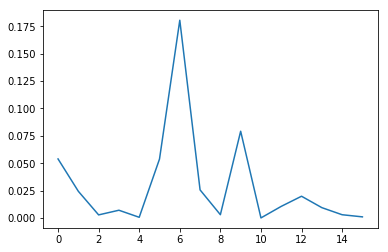

CPU times: user 7min 17s, sys: 12.7 s, total: 7min 29s
Wall time: 7min 31s


In [0]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 16

for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data

        opt.zero_grad()

        outputs = Net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(test_loader), evaluation(train_loader)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

#using GPU to increase efficiency

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = Net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
Net = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(Net.parameters())


In [34]:
%%time
max_epochs = 16

for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = Net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
    print('Epoch: %d/%d' % (epoch, max_epochs))

Epoch: 0/16
Epoch: 1/16
Epoch: 2/16
Epoch: 3/16
Epoch: 4/16
Epoch: 5/16
Epoch: 6/16
Epoch: 7/16
Epoch: 8/16
Epoch: 9/16
Epoch: 10/16
Epoch: 11/16
Epoch: 12/16
Epoch: 13/16
Epoch: 14/16
Epoch: 15/16
CPU times: user 3min 25s, sys: 2.61 s, total: 3min 27s
Wall time: 3min 28s


In [35]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(test_loader), evaluation(train_loader)))

Test acc: 98.85, Train acc: 99.63


#visualising our conv2D layers


In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


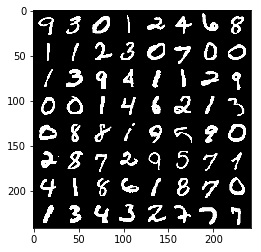

In [38]:
imshow(torchvision.utils.make_grid(images))

In [0]:
Net = Net.to('cpu')


In [72]:
out = Net(images)
print(out.shape)

torch.Size([64, 10])


In [73]:
out = Net.cnn_model[0](images)
out.shape

torch.Size([64, 6, 24, 24])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


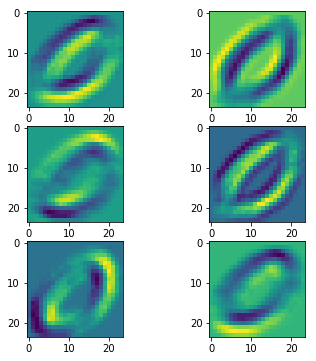

In [76]:
plt.figure(figsize = (6,6))
plt.subplot(321)
for i in range(6):
    ax1 = plt.subplot(3, 2, i+1)
    plt.imshow(out[2, i, :, :].detach().numpy())
plt.show()

In [80]:
out1 = Net.cnn_model[0](images)
out1.shape

torch.Size([64, 6, 24, 24])